# Data Masters Case: Agrupamentos Naturais

Felipe Viacava -- São Paulo, ago/2023

O presente documento consiste no desenvolvimento de modelos de agrupamento como parte da solução do Case "Data Masters - Cientista de Dados" do Santander Brasil.

O objetivo é identificar e avaliar agrupamentos naturais (_clusters_), e atribuílos a um _rank_ baseado no lucro esperado por cliente.

Na etapa de classificação, buscava-se maximizar o lucro total que um modelo preditivo poderia gerar ao banco numa campanha de retenção. Agrupamentos naturais, por outro lado, são criados de forma não supervisionada, de modo que não podemos utilizar falsos positivos e verdadeiros positivos encontrados nos modelos para avaliá-los, uma vez que não existe uma variável "TARGET" para determinar estas métricas.

Premissas adotadas nesta etapa:
- Adota-se o lucro esperado por cliente calculado na etapa anterior;
- Novo _pipeline_ de preprocessamento pois, em geral, modelos de agrupamento são sensíveis à distribuições quando tratamos de variáveis numéricas;
- Os _clusters_ são encontrados usando todos os dados, mas o lucro _per capita_ só é avaliado sobre a base de testes.

## Bibliotecas

In [1]:
# --- Data Exploration and Viz --- #
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from resources.customviz import \
    plot_components, \
    expl_var

# --- Data Preprocessing --- #
import numpy as np

# --- Pipelines --- #
from resources.prep import build_prep_cluster
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

# --- Model Loading --- #
import pickle

## Lucro estimado

Uma das vantagens de trabalhar com classes para criar modelos robustos é a portabilidade. Não apenas para fins de _deployment_, mas também para agilidade em seu uso para diferentes aplicações. Aqui, lemos o conjunto de testes e carregamos o modelo campeão previamente treinado para recriar a coluna de lucro esperado por cliente.

In [2]:
with open("models/hgb.pkl", "rb") as f:
    hgb = pickle.load(f)

In [3]:
test = pd \
    .read_csv('data/test.csv') \
    .assign(
        predicted = (
            lambda ldf:
            hgb.predict(ldf.drop("TARGET", axis=1))
        ),
        profit = (
            lambda ldf:
            ((ldf["TARGET"] * 100) - 10) * ldf["predicted"]
        ),
        origin = "test"
    )

train = pd \
    .read_csv('data/train.csv') \
    .assign(
        predicted = np.nan,
        profit = np.nan,
        origin = "train"
    )

df = pd.concat([train, test])
df

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET,predicted,profit,origin
0,111813,2,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,117310.979016,0,NaN,NaN,train
1,31053,2,79,105.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,68480.010000,0,NaN,NaN,train
2,136647,2,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,57517.740000,0,NaN,NaN,train
3,100343,2,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,60060.930000,0,NaN,NaN,train
4,9720,2,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,84028.740000,0,NaN,NaN,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15199,145076,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,55667.400000,0,0.0,0.0,test
15200,8976,2,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,117310.979016,0,0.0,0.0,test
15201,123578,2,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,72733.590000,0,0.0,0.0,test
15202,119823,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,115950.060000,0,0.0,0.0,test


In [4]:
reference = df[["ID", "TARGET", "predicted", "profit", "origin"]]
reference

,ID,TARGET,predicted,profit,origin
0,111813,0,NaN,NaN,train
1,31053,0,NaN,NaN,train
2,136647,0,NaN,NaN,train
3,100343,0,NaN,NaN,train
4,9720,0,NaN,NaN,train
...,...,...,...,...,...
15199,145076,0,0.0,0.0,test
15200,8976,0,0.0,0.0,test
15201,123578,0,0.0,0.0,test
15202,119823,0,0.0,0.0,test


## Processamento

Os passos de pré-processamento dos dados utilizados no modelo campeão serão reutilizados aqui, com exceção dos _encoders_ ordinais. Na classificação, foram usados _enconders_ ordinais para evitar o aumento de dimensionalidade, reduzindo o número de variáveis aleatórias necessárias por _split_ nas árvores, uma vez que lidam bem com relações não lineares entre variáveis independentes e a variável _target_. No caso da análise de clusters, foi escolhido o _One Hot Encoding_ para as features categóricas, além de outras manipulações para as variáveis numéricas.

In [5]:
cdf = df.drop(["TARGET","predicted","profit","origin"],axis=1)
prep = build_prep_cluster().fit(cdf)
prep

Pipeline(steps=[('base',
                 Pipeline(steps=[('DropConstantColumns',
                                  DropConstantColumns(also=['ID'])),
                                 ('DropDuplicateColumns',
                                  DropDuplicateColumns()),
                                 ('NoneZeroCountSaldo',
                                  AddNonZeroCount(prefix='saldo')),
                                 ('SumSaldo', CustomSum(prefix='saldo')),
                                 ('NoneZeroCountImp',
                                  AddNonZeroCount(prefix='imp')),
                                 ('SumImp', CustomSum(prefix='imp')),
                                 ('ImputeNanDelta',
                                  CustomI...
                              scaler=StandardScaler())),
                ('zh_ss',
                 PrefixScaler(prefixes=['non_zero_count_saldo', 'sum_of_imp'],
                              scaler=StandardScaler(), zero_heavy=True)),
                ('cat',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(min_frequency=100,
                                                                                 sparse_output=False)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['var36', 'var21'])])),
                ('knn', KNNImputer()), ('pca', PCA())])

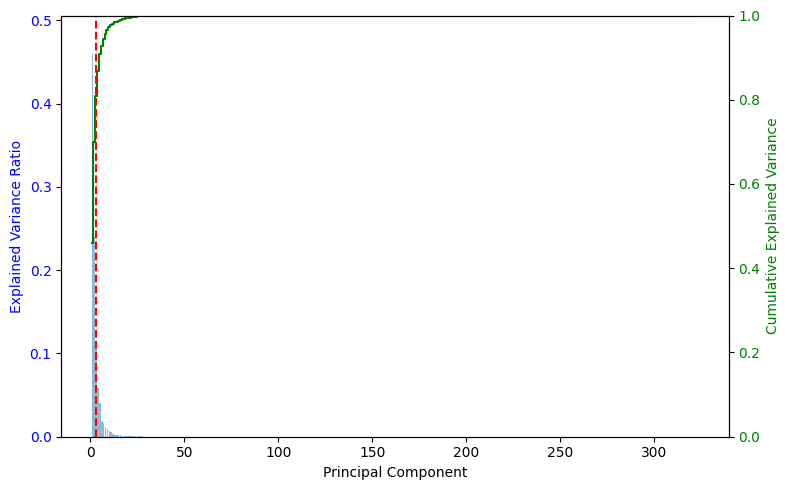

80% of variance is explained by 3 components


In [6]:
expl_var(prep[-1].explained_variance_ratio_)